# Adaptive Boosting
In this notebook, we implement boosting for a "least squares" classifier. This classifier performs least squares linear regression treating the $\pm 1$ class labels as real-valued responses. This classifier usually performs poorly, so boosting this classifier can be a good illustration of how weak learners can be combined to produce a strong learner.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy as cp

from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Occupancy Detection
We use a [dataset](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+) consisting of a binary ground truth (whether a room is occupied) and features for temperature, relative humidity, humidity ratio, light, and CO2. An additional column of 1's has been added to the X objects to facilitate learning the bias parameter. The data has been split into a training set consisting of 1036 observations and a test set consisting of 1000 observations.

In [2]:
data_path = os.path.join('data','boosting')

X_train = np.genfromtxt(os.path.join(data_path, 'X_train.csv'), delimiter = ',')
X_train = np.hstack([X_train, np.ones(X_train.shape[0]).reshape(-1,1)])
y_train = np.genfromtxt(os.path.join(data_path, 'y_train.csv'))

X_test = np.genfromtxt(os.path.join(data_path, 'X_test.csv'), delimiter = ',')
X_test = np.hstack([X_test, np.ones(X_test.shape[0]).reshape(-1,1)])
y_test = np.genfromtxt(os.path.join(data_path, 'y_test.csv'))

print('X_train has {} observations and {} features'.format(X_train.shape[0], X_train.shape[1]))
print('y_train has {} labels'.format(len(y_train)))
print('X_test has {} observations and {} features'.format(X_test.shape[0], X_test.shape[1]))
print('y_test has {} labels'.format(len(y_test)))

X_train has 1036 observations and 6 features
y_train has 1036 labels
X_test has 1000 observations and 6 features
y_test has 1000 labels


# Adaptive Boosting
At a high level, adaptive boosting works by combining several weak learners into a strong learner. A weak learner is fit to a boostrapped sample of the dataset, and based on how well it performs, it is assigned a "quality" score. The observations the weak learner misclassifies are given a greater weight so that the next weak learner must focus on what its predecessor failed to correctly classify. This second weak learner is also assigned a quality score, and the observations are further re-weighted for the subsequent weak learner. A boosted binary classifier then predicts for a given observation the sign of the weighted sum of the predictions of its weak learners weighted by their quality scores.

Concretely, we can describe the boosting algorithm as follows:

Given $(x_1, y_1), ..., (x_n, y_n), y \in \{-1,+1\}$, set $w_1(i) = \frac{1}{n}$ for $i = 1:n$.

For $t = 1, ..., T$:
1. Sample a boostrap dataset $\mathcal{B}_t$ of size $n$ according to distribution $w_t$. We pick $(x_i, y_i)$ with probability $w_t(i)$.
2. Fit classifier $f_t$ using data in $\mathcal{B}_t$.
3. Calculate a weighted error $\epsilon_t = \sum_{i=1}^{n}w_t(i)\mathbb{1}\{y_i \neq f_t(x_i)\}$ and estimator quality score $\alpha_t=\frac{1}{2}\ln(\frac{1-\epsilon_t}{\epsilon_2})$. If $\epsilon_t$ is small, $\alpha_t$ will be large.
4. Scale $\hat{w}_{t+1} = w_t(i)e^{-\alpha_ty_if_t(x_i)}$ and normalize so that $w_{t+1}(i) = \frac{\hat{w}_{t+1(i)}}{\sum_{j=1}^{n}\hat{w}_{t+1}(j)}$.

The booster classifier can then be defined as:
$$f_{boost}(x_0)=sign(\sum_{t=1}^{T}\alpha_tf_t(x_0))$$

In [3]:
class LeastSquaresClassifier:
    
    def __init__(self):
        return
    
    def fit(self, X, y):
        self.n_features = X.shape[1]
        # solve for weights w
        first = np.linalg.inv(np.dot(X.T,X))
        second = np.dot(X.T, y)
        self.weights = np.dot(first, second)

        # calculate degrees of freedom using previously computed 'first' variable
        df_matrix = X.dot(first).dot(X.T)
        self.df = np.trace(df_matrix)
        return self      
        
    def predict(self, X):
        preds = np.dot(X, self.weights)
        return np.sign(preds)
    
class AdaBoostRegressor():
    
    def __init__(self, estimator, n_iter = 1500, random_state=0,
                 diagnostic=False, X_test=None, y_test=None):
        np.random.seed(random_state)
        self.estimator = estimator
        self.n_iter = n_iter
        if diagnostic:
            assert(isinstance(X_test, np.ndarray) and 
                   isinstance(y_test, np.ndarray))
            self.diagnostic=True    
            self.X_test = X_test.copy()
            self.y_test = y_test.copy()
       
    def fit(self, X, y):
        n = X.shape[0]
        d = X.shape[1]
        
        # initial bootstrap sampling probability is uniform
        probas = np.ones(n) / n
        
        # collect history of relevant values
        self.history = dict(estimators=list(),
                            est_qualities=list(),
                            error_rates=list())
        if self.diagnostic:
            self.history['train_errors'] = list()
            self.history['test_errors'] = list()
            self.history['bootstrap_counts'] = list()
        
        for t in range(self.n_iter):
            
            # create a bootstrapped sample of the training data
            bootstrap_indices = np.random.choice(np.arange(n),
                                                 size=n,
                                                 p=probas,
                                                 replace=True)
            X_bootstrap = X[bootstrap_indices,:]
            y_bootstrap = y[bootstrap_indices]
            
            # fit estimator to boostrapped sample
            estimator = cp.deepcopy(self.estimator)
            estimator.fit(X_bootstrap, y_bootstrap)
            
            
            # calculate weighted error rate and estimator quality
            y_pred = estimator.predict(X)
            error_rate = probas[y != y_pred].sum()
            
            # if weighted error greater than 0.5, change sign of regression
            # ...vector and predictions, and recalculate weighted error
            if error_rate > 0.5:
                error_rate = 1 - error_rate
                estimator.weights = -estimator.weights
                y_pred = -y_pred  
            est_quality = 0.5 * np.log((1 - error_rate) / (error_rate + 0))
            
            # reweight sampling probabilities
            probas = probas * np.exp(-y * est_quality * y_pred)
            probas = probas / probas.sum()
            
            # log history
            self.history['estimators'].append(estimator)
            self.history['est_qualities'].append(est_quality)
            self.history['error_rates'].append(error_rate)
            
            if self.diagnostic:
                y_train_pred = self.predict(X)
                y_test_pred = self.predict(X_test)
                train_error = (y_train_pred != y).mean()
                test_error = (y_test_pred != y_test).mean()
                self.history['train_errors'].append(train_error)
                self.history['test_errors'].append(test_error)
                self.history['bootstrap_counts'].extend(list(bootstrap_indices))
            
        # convert lists to arrays
        for key in self.history.keys():
            self.history[key] = np.array(self.history[key])
            
        return self
    
    def predict(self, X):
        preds = list()
        for est in self.history['estimators']:
            preds.append(est.predict(X))
        preds = np.column_stack(preds)
        preds = preds.dot(self.history['est_qualities'])
        return np.sign(preds)

Below, we train a boosted least squares classifier for $T = 1500$ rounds and plot the training and testing error of $f_{boost}^{(t)}(\cdot)$ as a funtion of $t = 1:T$.

In [4]:
ls = LeastSquaresClassifier()
ada = AdaBoostRegressor(ls, n_iter=1500, diagnostic=True,
                        X_test=X_test, y_test=y_test)
ada.fit(X_train, y_train)

Past 600 iterations, the boosted classifier has a training error of 0. Fortunately, such overfitting does not cause the test error to increase dramatically. This behavior is commonly observed in boosted algorithms.

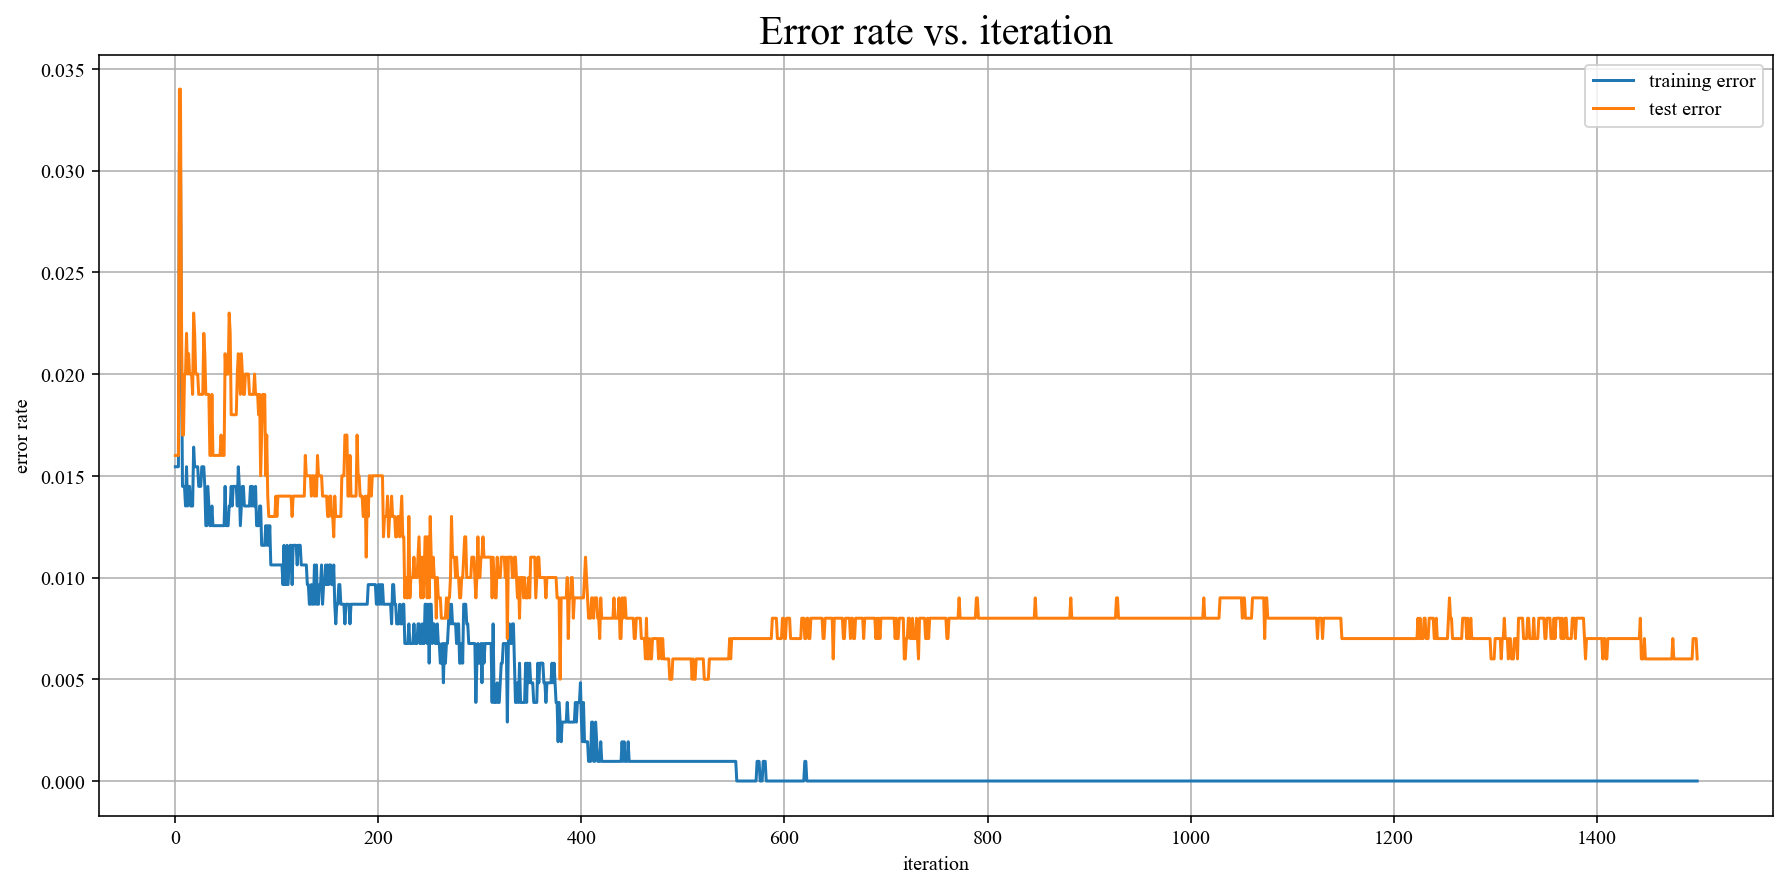

In [5]:
plt.figure(figsize=(15,7))
plt.plot(ada.history['train_errors'], label='training error')
plt.plot(ada.history['test_errors'], label='test error')
plt.ylabel('error rate')
plt.xlabel('iteration')
plt.title('Error rate vs. iteration', fontsize=20)
plt.legend()
plt.grid(True)

It can be shown that the training error of the boosted classifier $\frac{1}{n}\sum_{i=1}^{n}\mathbb{1}\{y_i \neq f_{boost}(x_i)\} \leq e^{-2\sum_{t=1}^{T}(\frac{1}{2} - \epsilon_t)^2}$. This upper bound is shown below as a function of iteration $t$ along with the training and testing errors from before.

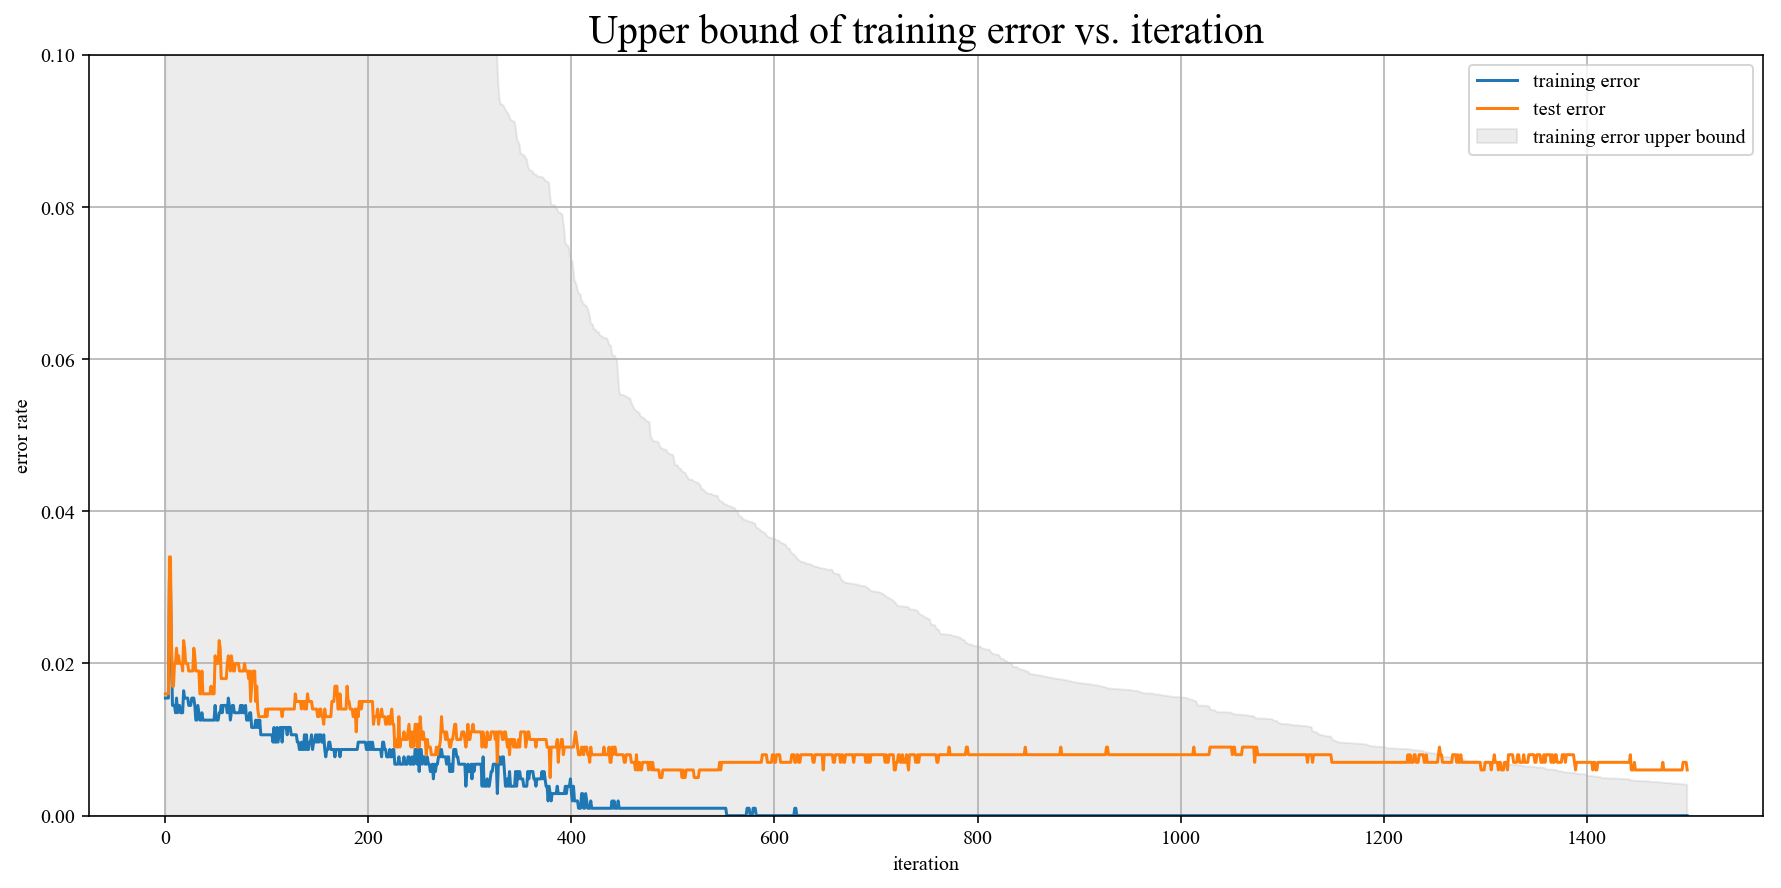

In [23]:
upper_bound = list()
error_rates = ada.history['error_rates']
for i in range(len(error_rates)):
    upper_bound.append(np.exp(-2 * ((1/2 - error_rates[:i+1])**2).sum()))

plt.figure(figsize=(15,7))
plt.title('Upper bound of training error vs. iteration', fontsize=20)
plt.plot(ada.history['train_errors'], label='training error')
plt.plot(ada.history['test_errors'], label='test error')
plt.fill_between(range(len(upper_bound)),0,upper_bound,
                 label='training error upper bound', alpha=0.15, color='gray')
plt.ylabel('error rate')
plt.ylim(0, 0.1)
plt.xlabel('iteration')
plt.legend()
plt.grid(True)

We also plot below a histogram of the total number of times each training data point was selected by the boostrap method across all rounds. The points that are sampled infrequently are easy to correctly classify while those sampled most frequently are the most difficult.

Text(0.5,1,'Distribution of training instances sampled')

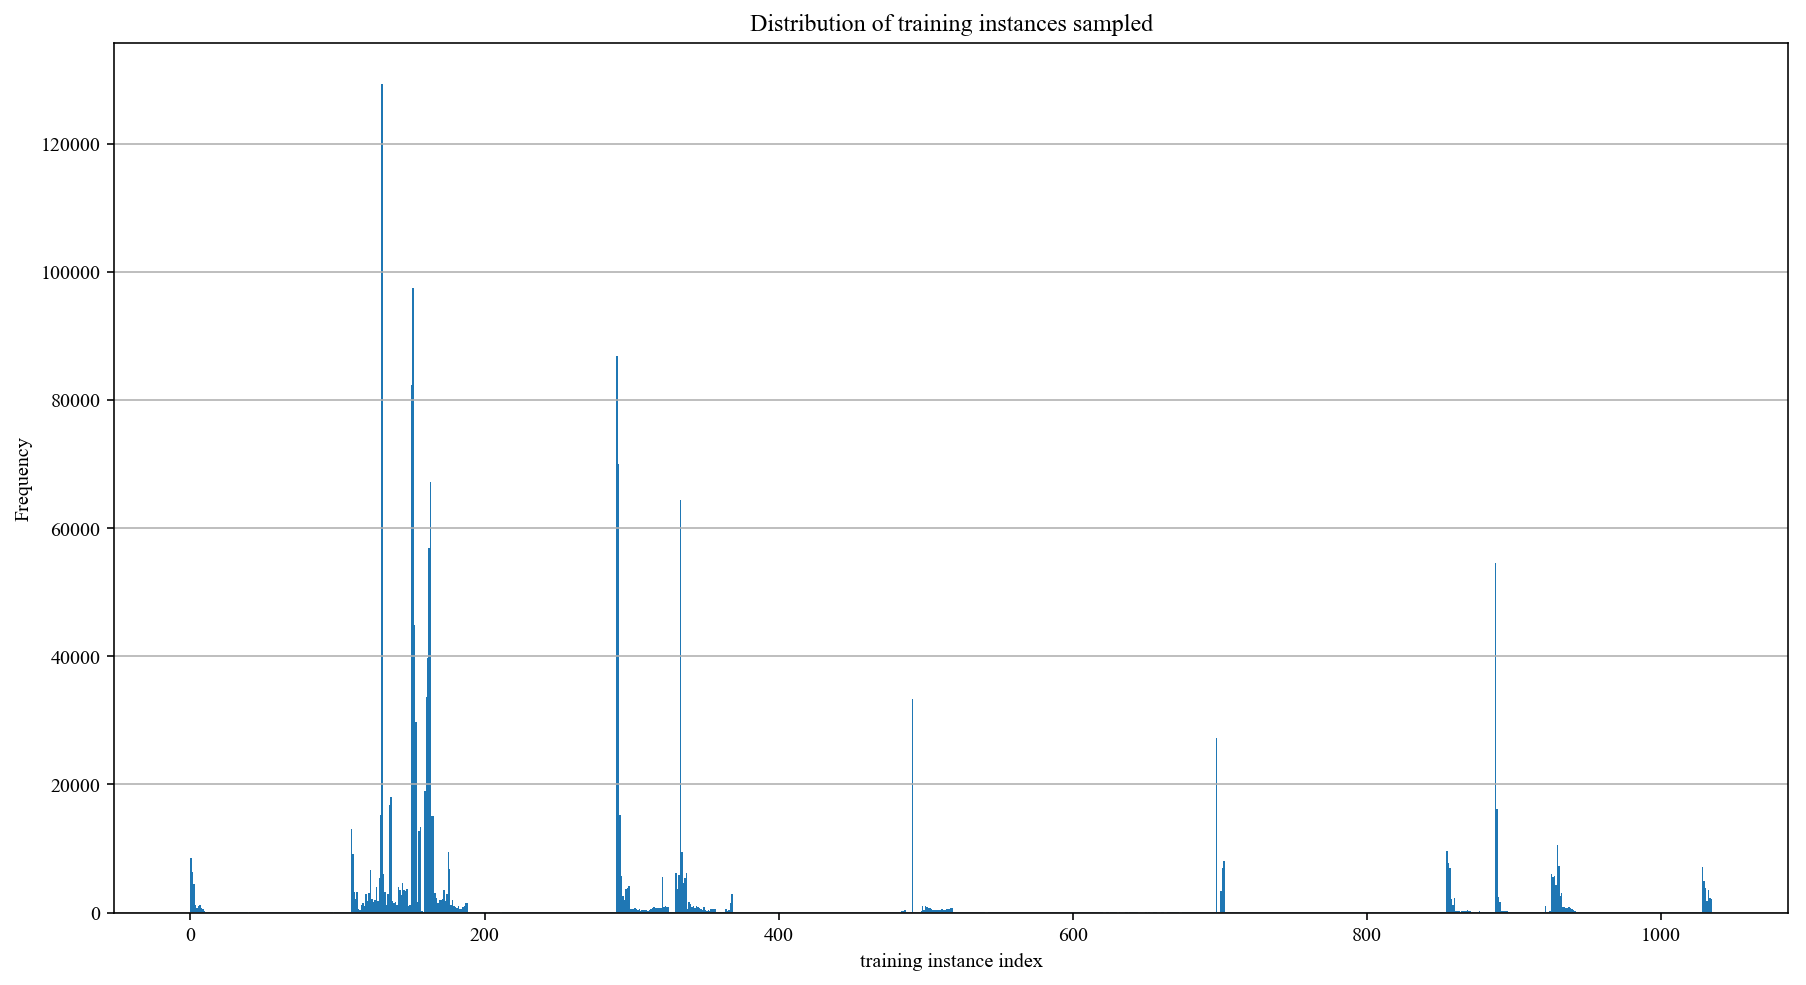

In [7]:
ax = pd.Series(ada.history['bootstrap_counts']).plot.hist(bins=len(X_train),
                                                          figsize=(15,8))
ax.yaxis.grid(True)
ax.set(xlabel = 'training instance index')
ax.set_title('Distribution of training instances sampled')

Finally, we plot the weighted error $\epsilon_t$ and estimtor quality $\alpha_t$ as a function of $t$. Even though the least squares classifier is considered a weak model for classification, for this data it performs reasonably well. Thus, the weighted error of the initial weak learner is quite low, resulting in an extremely high estimator quality score. However, this means that for the next learner, all previously misclassified points will be much more likely to be sampled into the boostrap set while all previously correctly classified points will be much less likely to be sampled, resulting in a boostrap set that is much more difficult for a least squares classifier, which is why subsequent weighted errors stabilize between 0.4 and 0.5 with corresponding estimator qualities between 0 and 0.25.

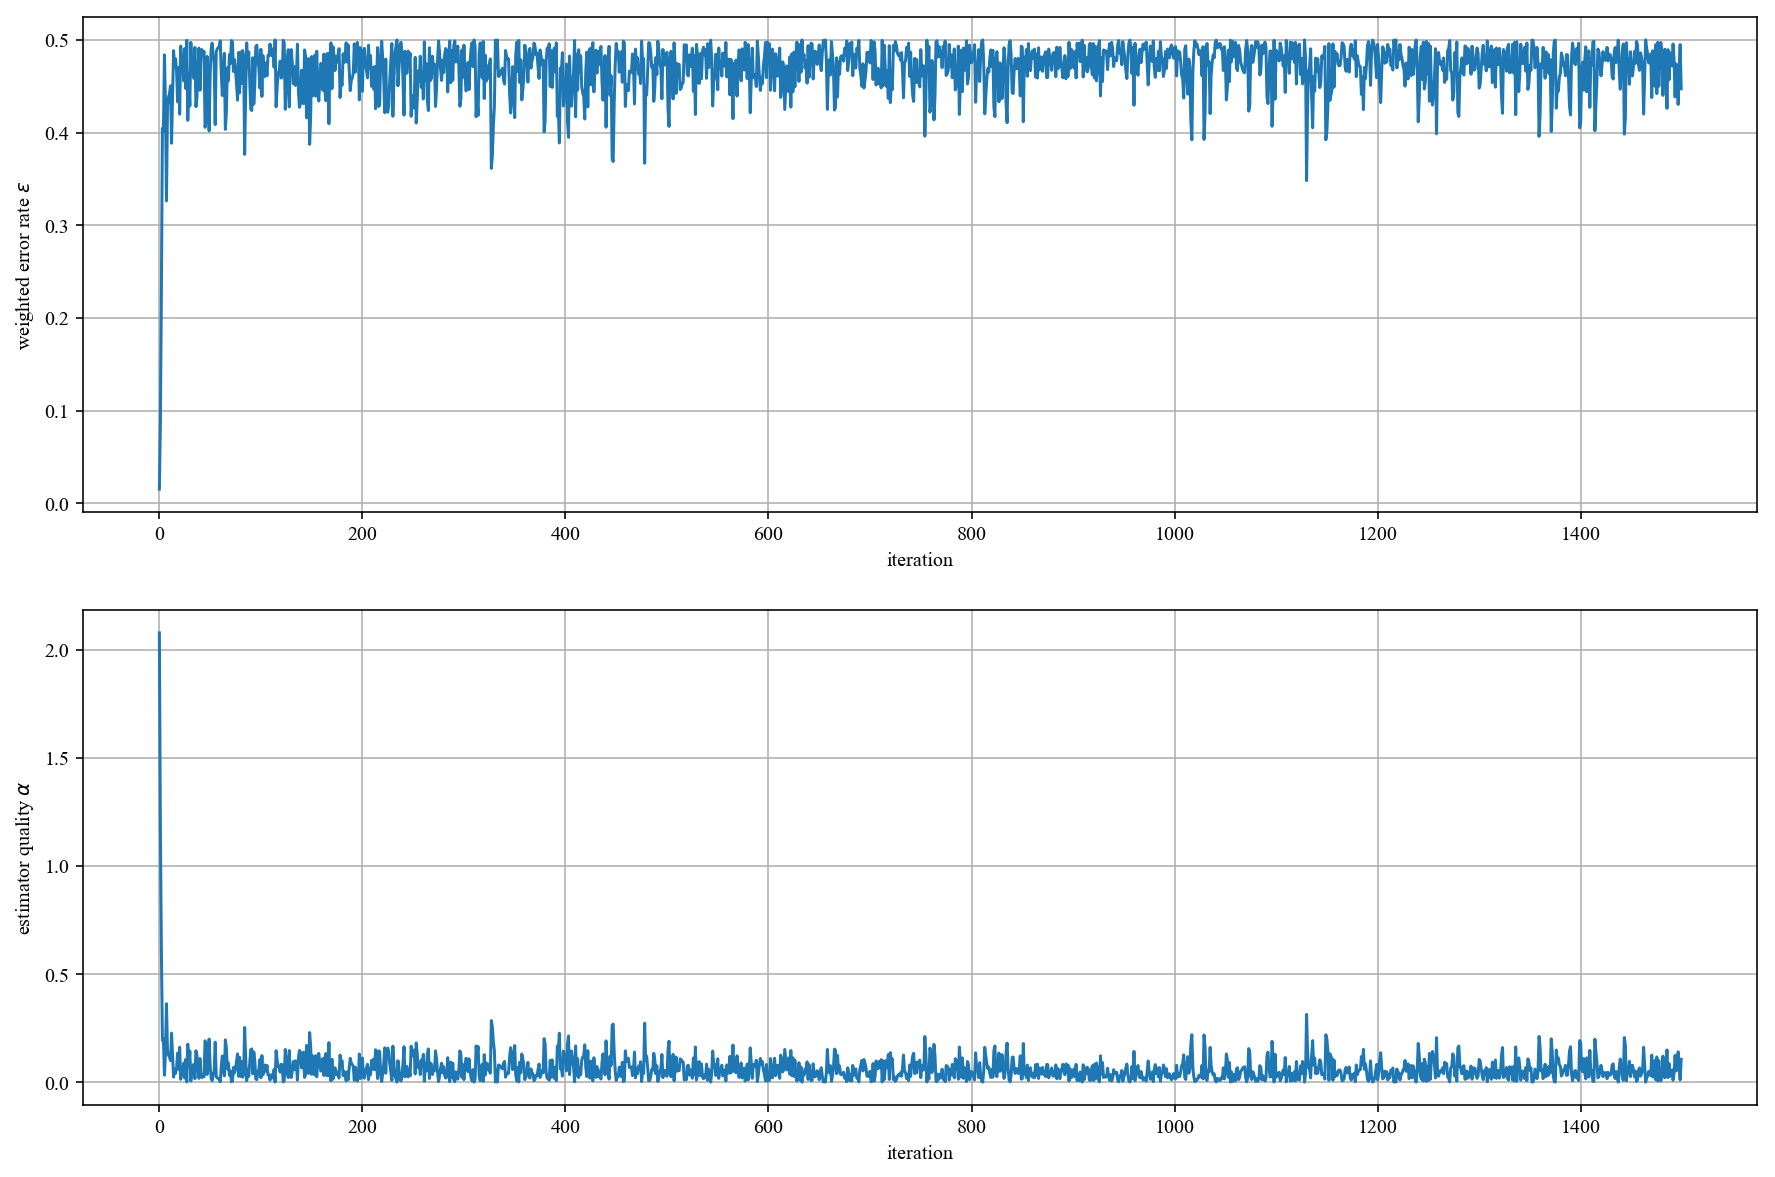

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(15,10))
axes[0].plot(ada.history['error_rates'])
axes[0].set(ylabel='weighted error rate $\epsilon$')
axes[1].plot(ada.history['est_qualities'])
axes[1].set(ylabel='estimator quality $\\alpha$')
for ax in axes:
    ax.grid(True)
    ax.set(xlabel = 'iteration')